# Making PI Kata


## The Math - Buffon's Needle
I've seen this demonstration before, seeing $\pi$ magically jump out of a seemingly random process, and got the immediate intuition about it. Until this kata I hadn't sat down and puzzled out the math. So, here goes...

The process is to lay out a grid of lines and drop "needles" on the grid, noting the number that cross grid lines, do some math on the results, and out pops $\pi$. But why does this work? Well, the intuion is that the needles are rotating, and wherever there are circles, there is $\pi$.

Working out the probability that a needle will cross a vertical line depends on the horizontal x-axis area covered by the rotated needle when projected to the x-axis. That distance divided by the total distance beteen lines gives a probability for any particular needle rotation. The trick is to sum up everything for each angle of rotation - and that means - calculus!

![My Scribble](Estpi.png)

## Solving

The projected x-axis distance $X_d$ of a rotated needle of length $L$:
$$X_d = L\cos \theta$$

Integrate over all possible $X_d$ (by sweeping through $90^{\circ}$) to obtain probability of crossing $P$:
$$P = \frac{\int_0^{\pi/2} L\cos \theta\,d\theta}{\int_0^{\pi/2} D\, d\theta}$$

Integrate... or, for even more fun, let's use [Wolfram Alpha](https://wolframalpha.com) :
![](wolfsnip.png)

Rearranging the resulting formula lets us estimate $\pi$. So, plunging ahead...

In [1]:
import random
from numpy import linspace
import matplotlib.pyplot as plt
from ipycanvas import Canvas, hold_canvas

In [2]:
random.seed()
width = 600
height = 400
numLines = 11
D = width / numLines
ratio = 1/3
lines = [i*D for i in range(numLines+1)]
L = (ratio)*D + 5
n = 500

## No math libraries!
To actually rotate things, I'll at least need square roots. This is Newton's method.

In [3]:
def sqrtn(n):
    if n < 0:
        raise Exception("sqrt of neg")
    if n == 0:
        return 0
    e = 1.0e-7
    k = n + 1
    while abs(n - k*k) > e:
        k1 = (k + n/k) / 2
        k = k1
    return k

Now we can rotate the unit radius (length 1) by rearranging the circle formula $r = \sqrt{x^2 + y^2}$:

$$y = \sqrt{1 - x^2}$$

In [4]:
samples = 1000
xs = linspace(0,1,samples) 
ys = [sqrtn(1 - x*x) for x in xs]

This will generate a randomly rotated line.

In [5]:
def randomRotatedLine(length):
    ox = random.random()*(width)
    oy = random.random()*(height)
    quad = random.choice([1,-1])
    idx = random.randint(0,samples-1)
    x = quad*xs[idx]*length
    y = ys[idx]*length
    return[[ox,oy],[ox+x,oy+y]]


The remaining functions determine line crossings and estimate $\pi$

In [6]:
def crosses(s,lines):
    for l in lines:
        if s[0][0] > s[1][0]:
            s[0], s[1] = s[1], s[0]
        if s[0][0] <= l and s[1][0] >= l:
            return True
    return False

In [34]:
def estimate():
    sticks = [randomRotatedLine(L) for _ in range(n)]
    crossed = sum([crosses(s,lines) for s in sticks])
    estimate = 0 if crossed == 0 else (2*ratio*n) / (crossed)
    return estimate, sticks, crossed

In [66]:
avgest, sticks, crossed = estimate()
print(f"est pi = {avgest}")

est pi = 3.1746031746031744


In [9]:
def drawline(s,canvas):
    canvas.begin_path()
    canvas.move_to(s[0][0],s[0][1])
    canvas.line_to(s[1][0],s[1][1])
    canvas.stroke()

## Visualize

In [33]:
canvas = Canvas(sync_image_data=True)
def saveFile(*args, **kwargs):
    canvas.to_file('sticks.png')
with hold_canvas(canvas):
    canvas.fill_style = 'white'
    canvas.stroke_style = 'green'
    canvas.fill_rect(0, 0, width, height)
    canvas.stroke_style = 'green'
    for l in lines:
        drawline([[l,0],[l,height]],canvas)
    for s in sticks:
        canvas.stroke_style = 'red' if crosses(s,lines) else 'black'
        drawline(s,canvas)
canvas.observe(saveFile,'image_data')
canvas


Canvas(layout=Layout(height='500px', width='700px'), size=(700, 500), sync_image_data=True)

![](sticks.png)

Showing distribution of estimates around $\pi$

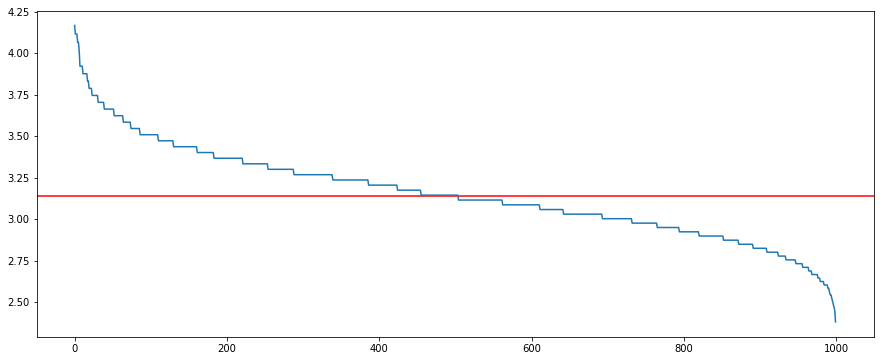

In [11]:
ests = [estimate()[0] for _ in range(1000)]
ests.sort(reverse=True)
plt.figure(figsize=(15,6))
plt.axhline(3.141,color='r')
plt.plot(range(1000),ests);
